![Advertising](img/advertising.jpeg)

**Prédire les ventes à partir des investissements publicitaires**

**Contexte** :

Une entreprise souhaite mieux comprendre l’impact de ses dépenses publicitaires sur ses ventes. Elle dispose d’un jeu de données ([`data/advertising.csv`](data/advertising.csv)) comprenant les montants investis dans trois canaux de communication (TV, radio, presse écrite) ainsi que les ventes correspondantes. Vous êtes chargé·e d’exploiter ces données pour construire un modèle de prédiction fiable.

⸻

🎯 **Objectif** :

Construire un modèle de régression linéaire permettant de prédire les ventes en fonction des investissements publicitaires dans les trois médias, en suivant un pipeline de modélisation complet.

- Exploration des données (EDA) :
    - Analyse descriptive
    - Visualisation des relations entre variables
    - Identification des corrélations
- Préparation des données :
    - Nettoyage des données (valeurs manquantes, outliers)
    - Normalisation ou standardisation si nécessaire
    - Séparation train/test
- Modélisation :
    - Implémentation d’un modèle de régression linéaire
- Évaluation :
    - Utilisation de métriques pertinentes : RMSE, R², MAE
- Intégration simple du modèle dans un script interactif
    - Intégrer votre modèle dans un script Python simple qui permet à un utilisateur de faire une prédiction à partir de nouvelles données.

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
import numpy as np
import joblib

### CHARGEMENT ET OBSERVATION DES DONNEES

In [10]:
# Création du dataframe
data = pd.read_csv("data/advertising.csv")

df = pd.DataFrame(data)
display(df)

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,14.0
197,177.0,9.3,6.4,14.8
198,283.6,42.0,66.2,25.5


In [ ]:
# Affichage des infos du dataframe
df.info()
# Pas de valeurs nulles

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [ ]:
# Affichage des corrélations avant nettoyage
df.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.901208
Radio,0.054809,1.000000,0.354104,0.349631
Newspaper,0.056648,0.354104,1.000000,0.157960
Sales,0.901208,0.349631,0.157960,1.000000


In [14]:
# Affichage des métriques générales du dataset
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


### NETTOYAGE DES DONNEES

In [ ]:
# Détection des valeurs extrêmes
def get_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return(
        lower_bound,
        upper_bound,
        df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    )

display(get_outliers(df, 'Sales'))
display(get_outliers(df, 'TV'))
display(get_outliers(df, 'Radio'))
display(get_outliers(df, 'Newspaper'))
# Des valeurs extrêmes dans la publicité papier. On va les nettoyer car une surdépense va réduire l'effet de chaque € dépensé

(np.float64(-1.075000000000001),
 np.float64(31.125),
 Empty DataFrame
 Columns: [TV, Radio, Newspaper, Sales]
 Index: [])

(np.float64(-142.29999999999998),
 np.float64(435.5),
 Empty DataFrame
 Columns: [TV, Radio, Newspaper, Sales]
 Index: [])

(np.float64(-29.849999999999994),
 np.float64(76.35),
 Empty DataFrame
 Columns: [TV, Radio, Newspaper, Sales]
 Index: [])

(np.float64(-35.775000000000006),
 np.float64(93.625),
         TV  Radio  Newspaper  Sales
 16    67.8   36.6      114.0   12.5
 101  296.4   36.3      100.9   23.8)

In [124]:
# Nettoyage des données extrêmes
lower_bound, upper_bound, _ = get_outliers(df, "Newspaper")
df = df[~((df["Newspaper"] < lower_bound) | (df["Newspaper"] > upper_bound))]

In [125]:
# Affichage des corrélations après nettoyage (aucun nettoyage nécessaire)
df.corr()

# Corrélation forte entre spots TV et ventes, presque significative entre Radio et ventes, non significative entre Newspaper et ventes

,TV,Radio,Newspaper,Sales
TV,1.000000,0.051978,0.049771,0.899974
Radio,0.051978,1.000000,0.346364,0.348566
Newspaper,0.049771,0.346364,1.000000,0.151764
Sales,0.899974,0.348566,0.151764,1.000000


### ETUDE DE L'INFLUENCE DES SPOTS TV

### PREPARATION DES DONNEES

In [77]:
# Séparation des jeux d'entrainement et de test
X = df[['TV']].values
y = df[['Sales']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=59)

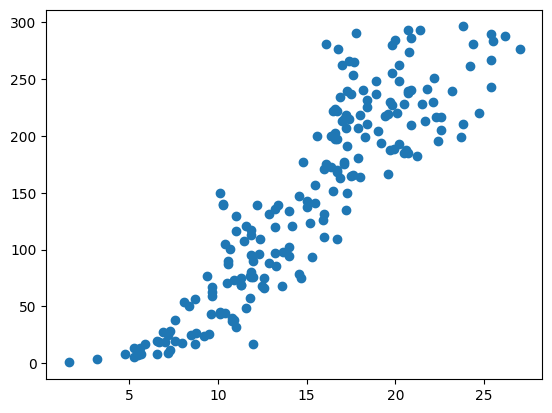

In [114]:
# Affichage des données
plt.scatter(df['Sales'], df['TV'])

In [78]:
# Standardisation des valeurs
scaler_X_tv = StandardScaler()
scaler_y_tv = StandardScaler()

X_train_scaled = scaler_X_tv.fit_transform(X_train)
y_train_scaled = scaler_y_tv.fit_transform(y_train)

X_test_scaled = scaler_X_tv.transform(X_test)
y_test_scaled = scaler_y_tv.transform(y_test)

### ENTRAINEMENT DU MODELE

In [79]:
model_tv = LinearRegression()
model_tv.fit(X_train_scaled, y_train_scaled)

LinearRegression()

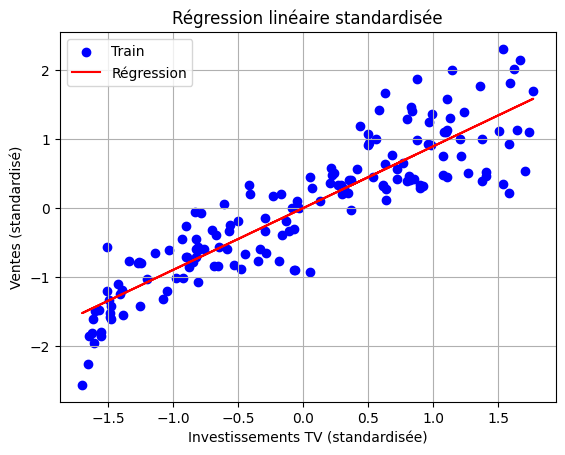

In [80]:
y_train_pred_scaled = model_tv.predict(X_train_scaled)
plt.scatter(X_train_scaled, y_train_scaled, color='blue', label='Train')
plt.plot(X_train_scaled, y_train_pred_scaled, color='red', label='Régression')
plt.title("Régression linéaire standardisée")
plt.xlabel("Investissements TV (standardisée)")
plt.ylabel("Ventes (standardisé)")
plt.legend()
plt.grid(True)
plt.show()

### EVALUATION

In [81]:
y_pred_scaled = model_tv.predict(X_test_scaled)
mse_train = mean_squared_error(y_test_scaled, y_pred_scaled)
print("MSE :", mse_train)
print("RMSE :", np.sqrt(mse_train))
print("R² :", r2_score(y_test_scaled, y_pred_scaled))

# Un R² de 0.84 est plutôt bon

MSE : 0.16761120146567335
RMSE : 0.40940347026579216
R² : 0.8445638125252478


### ETUDE DE L'INFLUENCE DES SPOTS RADIO

### PREPARATION DES DONNEES

In [82]:
# Séparation des jeux d'entrainement et de test
X = df[['Radio']].values
y = df[['Sales']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=59)

In [83]:
# Standardisation des valeurs
scaler_X_radio = StandardScaler()
scaler_y_radio = StandardScaler()

X_train_scaled = scaler_X_radio.fit_transform(X_train)
y_train_scaled = scaler_y_radio.fit_transform(y_train)

X_test_scaled = scaler_X_radio.transform(X_test)
y_test_scaled = scaler_y_radio.transform(y_test)

### ENTRAINEMENT DU MODELE

In [84]:
model_radio = LinearRegression()
model_radio.fit(X_train_scaled, y_train_scaled)

LinearRegression()

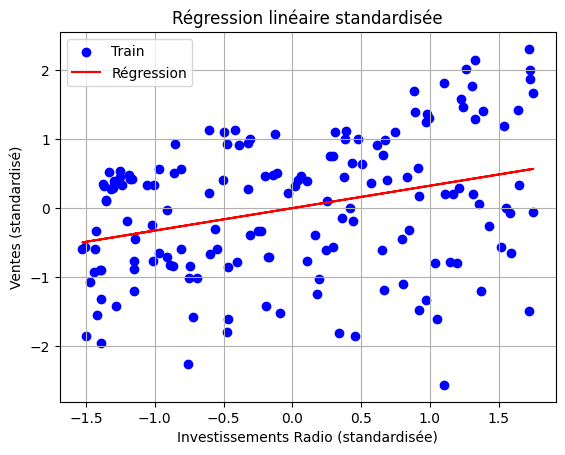

In [85]:
y_train_pred_scaled = model_radio.predict(X_train_scaled)
plt.scatter(X_train_scaled, y_train_scaled, color='blue', label='Train')
plt.plot(X_train_scaled, y_train_pred_scaled, color='red', label='Régression')
plt.title("Régression linéaire standardisée")
plt.xlabel("Investissements Radio (standardisée)")
plt.ylabel("Ventes (standardisé)")
plt.legend()
plt.grid(True)
plt.show()

### EVALUATION

In [86]:
y_pred_scaled = model_radio.predict(X_test_scaled)
mse_train = mean_squared_error(y_test_scaled, y_pred_scaled)
print("MSE :", mse_train)
print("RMSE :", np.sqrt(mse_train))
print("R² :", r2_score(y_test_scaled, y_pred_scaled))

# Un R² de 0.16 est mauvais. Le modèle est inefficace

MSE : 0.9069682417859346
RMSE : 0.952348802585447
R² : 0.15891250446792737


### ETUDE DE L'INFLUENCE DES PUBLICITES DANS LES JOURNAUX

### PREPARATION DES DONNEES

In [87]:
# Séparation des jeux d'entrainement et de test
X = df[['Newspaper']].values
y = df[['Sales']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=59)

In [88]:
# Standardisation des valeurs
scaler_X_newspaper = StandardScaler()
scaler_y_newspaper = StandardScaler()

X_train_scaled = scaler_X_newspaper.fit_transform(X_train)
y_train_scaled = scaler_y_newspaper.fit_transform(y_train)

X_test_scaled = scaler_X_newspaper.transform(X_test)
y_test_scaled = scaler_y_newspaper.transform(y_test)

### ENTRAINEMENT DU MODELE

In [89]:
model_newspaper = LinearRegression()
model_newspaper.fit(X_train_scaled, y_train_scaled)

LinearRegression()

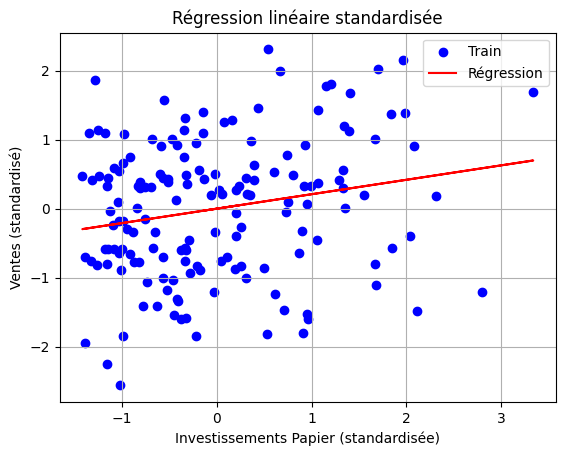

In [90]:
y_train_pred_scaled = model_newspaper.predict(X_train_scaled)
plt.scatter(X_train_scaled, y_train_scaled, color='blue', label='Train')
plt.plot(X_train_scaled, y_train_pred_scaled, color='red', label='Régression')
plt.title("Régression linéaire standardisée")
plt.xlabel("Investissements Papier (standardisée)")
plt.ylabel("Ventes (standardisé)")
plt.legend()
plt.grid(True)
plt.show()

### EVALUATION

In [91]:
y_pred_scaled = model_newspaper.predict(X_test_scaled)
mse_train = mean_squared_error(y_test_scaled, y_pred_scaled)
print("MSE :", mse_train)
print("RMSE :", np.sqrt(mse_train))
print("R² :", r2_score(y_test_scaled, y_pred_scaled))

# Un R² de -0.08 est totalement insignifiant. Le modèle est inefficace

MSE : 1.1654305591272092
RMSE : 1.0795510914853494
R² : -0.08077551675089878


### ETUDE DE L'INFLUENCE CONJOINTE DES PUBLICITES RADIO + JOURNAUX

### PREPARATION DES DONNEES

In [92]:
# Séparation des jeux d'entrainement et de test
X = df[['Newspaper', 'Radio']].values
y = df[['Sales']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=59)

In [93]:
# Standardisation des valeurs
scaler_X_radio_newspaper = StandardScaler()
scaler_y_radio_newspaper = StandardScaler()

X_train_scaled = scaler_X_radio_newspaper.fit_transform(X_train)
y_train_scaled = scaler_y_radio_newspaper.fit_transform(y_train)

X_test_scaled = scaler_X_radio_newspaper.transform(X_test)
y_test_scaled = scaler_y_radio_newspaper.transform(y_test)

### ENTRAINEMENT DU MODELE

In [94]:
model_radio_newspaper = LinearRegression()
model_radio_newspaper.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [95]:
y_train_pred_scaled = model_radio_newspaper.predict(X_train_scaled)


### EVALUATION

In [96]:
y_pred_scaled = model_radio_newspaper.predict(X_test_scaled)
mse_train = mean_squared_error(y_test_scaled, y_pred_scaled)
print("MSE :", mse_train)
print("RMSE :", np.sqrt(mse_train))
print("R² :", r2_score(y_test_scaled, y_pred_scaled))

# Un R² de 0.13 est totalement insignifiant. Le modèle est inefficace

MSE : 0.9336146239101895
RMSE : 0.9662373538164365
R² : 0.13420167362147095


### ETUDE DE L'INFLUENCE CONJOINTE DES PUBLICITES RADIO + TV

### PREPARATION DES DONNEES

In [97]:
# Séparation des jeux d'entrainement et de test
X = df[['Radio', 'TV']].values
y = df[['Sales']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=59)

In [98]:
# Standardisation des valeurs
scaler_X_radio_tv = StandardScaler()
scaler_y_radio_tv = StandardScaler()

X_train_scaled = scaler_X_radio_tv.fit_transform(X_train)
y_train_scaled = scaler_y_radio_tv.fit_transform(y_train)

X_test_scaled = scaler_X_radio_tv.transform(X_test)
y_test_scaled = scaler_y_radio_tv.transform(y_test)

### ENTRAINEMENT DU MODELE

In [99]:
model_radio_tv = LinearRegression()
model_radio_tv.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [100]:
y_train_pred_scaled = model_radio_tv.predict(X_train_scaled)

### EVALUATION

In [101]:
y_pred_scaled = model_radio_tv.predict(X_test_scaled)
mse_train = mean_squared_error(y_test_scaled, y_pred_scaled)
print("MSE :", mse_train)
print("RMSE :", np.sqrt(mse_train))
print("R² :", r2_score(y_test_scaled, y_pred_scaled))

# Un R² de 0.93 est excellenbt. Le modèle est très efficace

MSE : 0.07460171651940722
RMSE : 0.27313314796891136
R² : 0.9308172348062089


### ETUDE CONJOINTE DE L'INFLUENCE DES PUBLICITES TV, RADIO ET PAPIER

### PREPARATION DES DONNEES

In [126]:
# Séparation des jeux d'entrainement et de test
X = df[['Radio', 'TV', 'Newspaper']].values
y = df[['Sales']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=59)

In [127]:
# Standardisation des valeurs
scaler_X_full = StandardScaler()
scaler_y_full = StandardScaler()

X_train_scaled = scaler_X_full.fit_transform(X_train)
y_train_scaled = scaler_y_full.fit_transform(y_train)

X_test_scaled = scaler_X_full.transform(X_test)
y_test_scaled = scaler_y_full.transform(y_test)

### ENTRAINEMENT DU MODELE

In [128]:
model_full = LinearRegression()
model_full.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [129]:
y_train_pred_scaled = model_full.predict(X_train_scaled)

### EVALUATION

In [ ]:
y_pred_scaled = model_full.predict(X_test_scaled)
mse_train = mean_squared_error(y_test_scaled, y_pred_scaled)
print("MSE :", mse_train)
print("RMSE :", np.sqrt(mse_train))
print("R² :", r2_score(y_test_scaled, y_pred_scaled))

# Un R² de 0.94 est excellenbt. Le modèle est très efficace

MSE : 0.059210653841318
RMSE : 0.24333239373605398
R² : 0.9381187702122677


### CHOIX DU MODELE FINAL

Au final trois modèles se distinguent par leur efficacité : celui reposant uniquement sur l'étude de l'influence des spots TV, celui observant conjointement l'influence TV + Radio, et celui tenant compte des trois (Journaux, TV et Radio)

Comparons leurs métriques pour choisir le meilleur

TV :
MSE : 0.16761120146567335
RMSE : 0.40940347026579216
R² : 0.8445638125252478

TV + Radio :
MSE : 0.07460171651940722
RMSE : 0.27313314796891136
R² : 0.9308172348062089

TV + Radio + Journaux :
MSE : 0.059210653841318
RMSE : 0.24333239373605398
R² : 0.9381187702122677

Bien qu'efficace, le modèle reposant uniquement sur l'étude des spots TV a un R² très inférieur aux deux autres, nous l'écarterons donc
Les deux autres modèles sont très proches en termes de performances mais celui qui tient compte des 3 types a un R² supérieur mais surtout un MSE supérieur. On gardera le modèle complet demandé par le client, en soulignant que la publicité papier semble assez peu porteuse et que la publicité TV semble extrêmement efficace en terme de ventes/€ dépensé.

### SAUVEGARDE DU MODELE

In [131]:
# Sauvegarde du modèle de régression
joblib.dump(model_full, "models/model_regression.pkl")

# Sauvegarde du standardiseur des variables explicatives (X)
joblib.dump(scaler_X_full, "models/scaler_X.pkl")

# Sauvegarde du standardiseur de la variable cible (y), si utilisé (ex : pour une régression)
joblib.dump(scaler_y_full, "models/scaler_y.pkl")

['models/scaler_y.pkl']

### UTILISATION DU MODELE

In [133]:
# 1. Charger le modèle et les scalers
loaded_model = joblib.load("models/model_regression.pkl")
loaded_scaler_X = joblib.load("models/scaler_X.pkl")
loaded_scaler_y = joblib.load("models/scaler_y.pkl")

# 2. Proposer un input a l'utilisateur
radio_investment = input("Combien allez vous investir en spots radio ?")
tv_investment = input("Combien allez vous investir en spots TV ?")
newspaper_investment = input("Combien allez vous investir en publicités papier ?")

# 3. Transformer l’entrée
investment = np.array([[radio_investment, tv_investment, newspaper_investment]])
investment_scaled = loaded_scaler_X.transform(investment)

# 4. Prédiction standardisée
sales_scaled = loaded_model.predict(investment_scaled)

# 5. Revenir à l’échelle réelle
real_sales = loaded_scaler_y.inverse_transform(sales_scaled)

print(f"La prédiction de ventes pour {radio_investment}k€ d'investissement radio, {newspaper_investment}k€ d'investissement dans la presse papier et {tv_investment}k€ d'investissement TV est d'environ {real_sales[0][0]:,.2f}k ventes")

La prédiction de ventes pour 18k€ d'investissement radio, 500k€ d'investissement dans la presse papier et 20k€ d'investissement TV est d'environ 9.55k ventes
